<a id='Problem'></a>
<h1 style="color:#ffffff; background-color:#FF0000; border: 1px solid #ffffff; padding: 10px 0;">Title: Descriptive Analysis of VTuber Engagement Using Kaggle Data</h1>

The rise of VTubers, or virtual YouTubers, has become a significant cultural phenomenon, captivating millions of viewers worldwide. However, despite their immense popularity, there is limited understanding of the underlying metrics that drive engagement and define viewership trends in this unique digital space. The purpose of this descriptive analysis is to investigate key patterns in VTuber content creation, viewer demographics, and engagement across major social platforms to offer insights into the factors fueling the VTuber industry's growth.

This analysis leverages the VTuber 1B Dataset, a vast repository containing over 58 million data points, including live chat messages, superchat donations, and moderation events spanning 377 VTuber channels. By analyzing this extensive dataset, we aim to decode audience engagement behaviors, track financial contributions through superchats, and assess real-time interactions within VTuber live streams.

<a id='Problem'></a>
<h1 style="color:#ffffff; background-color:#FF0000; border: 1px solid #ffffff; padding: 10px 0;">I. Problem Statement</h1>

The VTuber industry has rapidly transformed from a niche trend into a major entertainment sector, drawing millions of fans globally. With the advent of virtual avatars as content creators, VTubers offer a unique viewing experience that combines animation, interactivity, and traditional streaming dynamics. However, despite the substantial and growing audience base, there is limited research into the specific engagement metrics that define their popularity. The objective of this descriptive analysis is to uncover trends related to VTuber content creation, viewer demographics, and platform engagement using available data.

<a id='Problem'></a>
<h1 style="color:#ffffff; background-color:#FF0000; border: 1px solid #ffffff; padding: 10px 0;">II. Datasets</h1>

VTuber 1B is a dataset for large-scale academic research, collecting over a billion live chats, superchats, and moderation events (bans/deletions) from virtual YouTubers' live streams.  This data captures viewer engagement patterns, financial contributions through superchats, and real-time interactions within VTuber live streams.

The Honeybee cluster is used to gather real-time live chat events from major VTubers' live streams. To protect user privacy, sensitive information such as author names and profile images are excluded from the dataset, and author channel IDs are anonymized using the SHA-1 hashing algorithm with an added layer of security.

VTuber 1B: VTuber 1B is most suitable for frequency analysis. This edition includes only the essential columns in order to reduce dataset size and make it faster fro Kaggle Kernels to load data in. Ban and deletion are equivalent to markChatItemsByAuthorAsDeletedAction and markChatItemAsDeletedAction respectively.

    | Filename                   | Summary                          |
    |----------------------------|----------------------------------|
    | chats_%Y-%m.parquet        | Live chat events (> 1,000,000,000) |
    | superchats_%Y-%m.parquet   | Super chat events (> 4,000,000) |
    | deletion_events.parquet    | Deletion events                 |
    | ban_events.parquet         | Ban events                      |

<a id='Problem'></a>
<h1 style="color:#ffffff; background-color:#FF0000; border: 1px solid #ffffff; padding: 10px 0;">III. Methodology</h1>

### 1. Data Pre-processing and Initialization

These three imports together provide the tools needed to load, manipulate, and visualize data effectively in Python. `pandas` handles the data, while `matplotlib` and `seaborn` offer options for visualization. Furthermore, Shown isthe display of the disk usage of each file or subdirectory inside /mnt/data/public/vtuber/ in a human-readable format, along with a total of all sizes combined at the end.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!du -sch /mnt/data/public/vtuber/*

26M	/mnt/data/public/vtuber/ban_events.parquet
65M	/mnt/data/public/vtuber/chats_2021-01.parquet
1.3G	/mnt/data/public/vtuber/chats_2021-02.parquet
2.8G	/mnt/data/public/vtuber/chats_2021-03.parquet
2.7G	/mnt/data/public/vtuber/chats_2021-04.parquet
3.2G	/mnt/data/public/vtuber/chats_2021-05.parquet
3.2G	/mnt/data/public/vtuber/chats_2021-06.parquet
3.4G	/mnt/data/public/vtuber/chats_2021-07.parquet
4.3G	/mnt/data/public/vtuber/chats_2021-08.parquet
3.8G	/mnt/data/public/vtuber/chats_2021-09.parquet
3.6G	/mnt/data/public/vtuber/chats_2021-10.parquet
3.5G	/mnt/data/public/vtuber/chats_2021-11.parquet
7.7G	/mnt/data/public/vtuber/chats_2021-12.parquet
4.3G	/mnt/data/public/vtuber/chats_2022-01.parquet
3.8G	/mnt/data/public/vtuber/chats_2022-02.parquet
4.3G	/mnt/data/public/vtuber/chats_2022-03.parquet
4.5G	/mnt/data/public/vtuber/chats_2022-04.parquet
4.4G	/mnt/data/public/vtuber/chats_2022-05.parquet
4.1G	/mnt/data/public/vtuber/chats_2022-06.parquet
4.6G	/mnt/data/public/vtuber/chats_2

In [5]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("LargeParquetLoad") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.sql.execution.arrow.enabled", "true") \
    .getOrCreate()

In [6]:
# List of file paths
file_paths_chats = [
    "/mnt/data/public/vtuber/chats_2021-07.parquet",
    "/mnt/data/public/vtuber/chats_2021-08.parquet",
    "/mnt/data/public/vtuber/chats_2021-09.parquet",
    "/mnt/data/public/vtuber/chats_2021-10.parquet",
    "/mnt/data/public/vtuber/chats_2021-11.parquet",
    "/mnt/data/public/vtuber/chats_2021-12.parquet"
]

# List of file paths for superchat data
file_paths_superchat = [
    "/mnt/data/public/vtuber/superchats_2021-07.parquet",
    "/mnt/data/public/vtuber/superchats_2021-08.parquet",
    "/mnt/data/public/vtuber/superchats_2021-09.parquet",
    "/mnt/data/public/vtuber/superchats_2021-10.parquet",
    "/mnt/data/public/vtuber/superchats_2021-11.parquet",
    "/mnt/data/public/vtuber/superchats_2021-12.parquet"
]

In [7]:
# Initialize an empty DataFrame for combining all files
df_combined_chats = None

In [8]:
# Initialize an empty DataFrame for combining all files
df_combined_chats = None

# Loop through each file, read it, and union it with df_combined_chats
for file_path in file_paths_chats:
    df = spark.read.parquet(file_path)
    df_combined_chats = df if df_combined_chats is None else df_combined_chats.union(df)

In [9]:
# Register the combined DataFrame as a view to run SQL queries
df_combined_chats.createOrReplaceTempView("chats_combined")

In [10]:
# Displaying the first 10 rows from the combined DataFrame
spark.sql("""
SELECT 
    *
FROM 
    chats_combined
LIMIT 10
""").show()

+--------------------+--------------------+-----------+--------------------+--------+----------+
|           timestamp|     authorChannelId|    videoId|           channelId|isMember|bodyLength|
+--------------------+--------------------+-----------+--------------------+--------+----------+
|2021-07-01T00:00:...|5efbc39287a6d3a27...|1y6n0ftUDL8|UCtzCQnCT9E4o6U3m...|   false|         8|
|2021-07-01T00:00:...|e32f9f60782378481...|IhiievWaZMI|UCS9uQI-jC3DE0L4I...|   false|         2|
|2021-07-01T00:00:...|f168422928baa6b5e...|Z139LhmhIQw|UCS9uQI-jC3DE0L4I...|    true|         3|
|2021-07-01T00:00:...|da38f78a2d12fca59...|b2B4hC6Dh6w|UCGNI4MENvnsymYjK...|   false|         2|
|2021-07-01T00:00:...|7c08c62ea9e69f40d...|F8f5frua5HA|UC6tSB9TnO0f01OBe...|   false|        63|
|2021-07-01T00:00:...|ee81fc2962b6bafe1...|2Ekz8COjWiY|UCBQd84IW8OvM8H5j...|   false|         4|
|2021-07-01T00:00:...|523dcb05edfbb615e...|b2B4hC6Dh6w|UCGNI4MENvnsymYjK...|   false|         1|
|2021-07-01T00:00:...|74d80c04

In [11]:
df_combined_chats.printSchema()
df_combined_chats.count()

root
 |-- timestamp: string (nullable = true)
 |-- authorChannelId: string (nullable = true)
 |-- videoId: string (nullable = true)
 |-- channelId: string (nullable = true)
 |-- isMember: boolean (nullable = true)
 |-- bodyLength: integer (nullable = true)



537205028

## 2. Checking  Null Values

In [12]:
null_count = df_combined_chats.filter(df_combined_chats.authorChannelId.isNull()).count()
print(f"Number of null authorChannelId entries: {null_count}")

Number of null authorChannelId entries: 0


In [13]:
null_count = df_combined_chats.filter(df_combined_chats.authorChannelId.isNull()).count()
print(f"Number of null authorChannelId entries: {null_count}")

Number of null authorChannelId entries: 0


In [14]:
# Initialize an empty DataFrame for combining all files
df_combined_superchats = None

In [15]:
# Loop through each file, read it, and union it with df_combined_superchats
for file_path in file_paths_superchat:
    df = spark.read.parquet(file_path)
    df_combined_superchats = df if df_combined_superchats is None else df_combined_superchats.union(df)

# Register the combined DataFrame as a view to run SQL queries
df_combined_superchats.createOrReplaceTempView("superchats_combined")

In [16]:
# Displaying the first 10 rows from the combined DataFrame
spark.sql("""
SELECT 
    *
FROM 
    superchats_combined
LIMIT 10
""").show()

+--------------------+------+--------+------------+--------------------+-----------+--------------------+----------+
|           timestamp|amount|currency|significance|     authorChannelId|    videoId|           channelId|bodylength|
+--------------------+------+--------+------------+--------------------+-----------+--------------------+----------+
|2021-07-01T00:00:...|  20.0|     MXN|           2|79a5ff510fc256341...|F8f5frua5HA|UC6tSB9TnO0f01OBe...|        32|
|2021-07-01T00:00:...| 500.0|     JPY|           3|bd0c48f217f806c74...|ZSkSRGG_opQ|UC_9nmotxi7FAfiJp...|        61|
|2021-07-01T00:00:...| 610.0|     JPY|           3|27543b8ef651e158b...|jBZoTsZ8KKk|UCmovZ2th3Sqpd00F...|        39|
|2021-07-01T00:00:...| 610.0|     JPY|           3|823ae7b14ad159a52...|jBZoTsZ8KKk|UCmovZ2th3Sqpd00F...|        53|
|2021-07-01T00:00:...| 500.0|     JPY|           3|573c1de147c9854cb...|1y6n0ftUDL8|UCtzCQnCT9E4o6U3m...|        17|
|2021-07-01T00:00:...| 500.0|     JPY|           3|4bbe065724afe

In [17]:
# Print the schema of the combined superchats DataFrame
df_combined_superchats.printSchema()
df_combined_superchats.count()

root
 |-- timestamp: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- currency: string (nullable = true)
 |-- significance: long (nullable = true)
 |-- authorChannelId: string (nullable = true)
 |-- videoId: string (nullable = true)
 |-- channelId: string (nullable = true)
 |-- bodylength: long (nullable = true)



2332512

In [18]:
# Count the number of null entries in the authorChannelId column for df_combined_superchats
null_count_superchats = df_combined_superchats.filter(df_combined_superchats.authorChannelId.isNull()).count()
print(f"Number of null authorChannelId entries in df_combined_superchats: {null_count_superchats}")

Number of null authorChannelId entries in df_combined_superchats: 0


### 3. Loading

In [19]:
#Load different datasets in the vtuber directory
df_ban_events = spark.read.parquet("/mnt/data/public/vtuber/ban_events.parquet")
df_deletion_events = spark.read.parquet("/mnt/data/public/vtuber/deletion_events.parquet")

In [25]:
# Loading ban events data
df_ban_events = spark.read.parquet("/mnt/data/public/vtuber/ban_events.parquet")

# Displaying the first few rows of ban events data to verify loading
df_ban_events.show(5)

+--------------------+--------------------+-----------+--------------------+
|           timestamp|     authorChannelId|    videoId|           channelId|
+--------------------+--------------------+-----------+--------------------+
|2021-02-11 09:52:...|28b911656881fefae...|0vDIyNgVyZI|UCYz_5n-uDuChHtLo...|
|2021-02-11 09:54:...|20035eb4b063278b8...|0vDIyNgVyZI|UCYz_5n-uDuChHtLo...|
|2021-02-11 09:58:...|524e0b58909a1c6dc...|blSX7M_n9RA|UCl_gCybOJRIgOXw6...|
|2021-02-11 09:58:...|524e0b58909a1c6dc...|blSX7M_n9RA|UCl_gCybOJRIgOXw6...|
|2021-02-11 10:08:...|8a68f6998263072fc...|-UbSxTkVjjU|UC-hM6YJuNYVAmUWx...|
+--------------------+--------------------+-----------+--------------------+
only showing top 5 rows



In [26]:
df_deletion_events.show(5)

+--------------------+--------------------+---------+-----------+--------------------+
|           timestamp|                  id|retracted|    videoId|           channelId|
+--------------------+--------------------+---------+-----------+--------------------+
|2021-02-11 09:03:...|CkUKGkNQM21yOTY4N...|     true|b2O8RqGXxwM|UCCzUftO8KOVkV4wQ...|
|2021-02-11 09:04:...|CjsKGkNLV1F0T1c4N...|     true|blSX7M_n9RA|UCl_gCybOJRIgOXw6...|
|2021-02-11 09:04:...|CkUKGkNLelE4dC04N...|     true|blSX7M_n9RA|UCl_gCybOJRIgOXw6...|
|2021-02-11 09:06:...|CjsKGkNMVDIxNmk5N...|     true|FBHae81fR3U|UCNVEsYbiZjH5QLmG...|
|2021-02-11 09:06:...|CkUKGkNNejA0S3E5N...|     true|2RLmJw5Wb5k|UCHsx4Hqa-1ORjQTh...|
+--------------------+--------------------+---------+-----------+--------------------+
only showing top 5 rows



### 4. Filtering
This function filters an events DataFrame to only include records within a specific date range, based on the timestamp column. It's helpful for time-based analyses, allowing you to focus on events occurring between two given dates.

In [27]:
from pyspark.sql import functions as F
from pyspark.sql import DataFrame

def filter_events_by_date(df: DataFrame, start_date: str, end_date: str) -> DataFrame:
    """
    Filters an events DataFrame for entries within a specified date range.

    Parameters:
    - df (DataFrame): The events DataFrame to filter.
    - start_date (str): Start date in the format 'YYYY-MM-DD'.
    - end_date (str): End date in the format 'YYYY-MM-DD'.

    Returns:
    - DataFrame: Filtered DataFrame within the date range.
    """
    # Convert timestamp to DateType
    df = df.withColumn("date", F.to_date("timestamp"))

    # Filter for rows within the date range
    filtered_df = df.filter((F.col("date") >= start_date) & (F.col("date") <= end_date))
    
    return filtered_df.drop("date")  # Drop the extra date column if not needed

In [28]:
# Applying the function to both df_ban_events and df_deletion_events
filtered_df_ban_events = filter_events_by_date(df_ban_events, "2021-07-01", "2021-12-31")
filtered_df_deletion_events = filter_events_by_date(df_deletion_events, "2021-07-01", "2021-12-31")

# Displaying the first few rows to verify
filtered_df_ban_events.show(5)
filtered_df_deletion_events.show(5)

+--------------------+--------------------+-----------+--------------------+
|           timestamp|     authorChannelId|    videoId|           channelId|
+--------------------+--------------------+-----------+--------------------+
|2021-07-01 00:00:...|2be0ae450be9719dd...|F8f5frua5HA|UC6tSB9TnO0f01OBe...|
|2021-07-01 00:04:...|a6bd8001a64644931...|jBZoTsZ8KKk|UCmovZ2th3Sqpd00F...|
|2021-07-01 00:04:...|73f95df4197dd428a...|Z139LhmhIQw|UCS9uQI-jC3DE0L4I...|
|2021-07-01 00:04:...|a6bd8001a64644931...|jBZoTsZ8KKk|UCmovZ2th3Sqpd00F...|
|2021-07-01 00:05:...|14de35653fd2225e5...|F8f5frua5HA|UC6tSB9TnO0f01OBe...|
+--------------------+--------------------+-----------+--------------------+
only showing top 5 rows

+--------------------+--------------------+---------+-----------+--------------------+
|           timestamp|                  id|retracted|    videoId|           channelId|
+--------------------+--------------------+---------+-----------+--------------------+
|2021-07-01 00:00:...

<a id='Problem'></a>
<h1 style="color:#ffffff; background-color:#FF0000; border: 1px solid #ffffff; padding: 10px 0;">IV. Analysis</h1>

### 1. Frequencies

In [29]:
from pyspark.sql import functions as F

# Example 1: Count rows in each DataFrame
print("Ban Events:", filtered_df_ban_events.count())
print("Deletion Events:", filtered_df_deletion_events.count())
print("Chats Combined:", df_combined_chats.count())
print("Superchats Combined:", df_combined_superchats.count())

Ban Events: 199976
Deletion Events: 1502610
Chats Combined: 537205028
Superchats Combined: 2332512


In [30]:
# Activity per day (ban events)
ban_daily_counts = filtered_df_ban_events.withColumn("date", F.to_date("timestamp")) \
    .groupBy("date").count() \
    .orderBy("date")
ban_daily_counts.show()

+----------+-----+
|      date|count|
+----------+-----+
|2021-07-01| 1492|
|2021-07-02|  890|
|2021-07-03| 1181|
|2021-07-04|  779|
|2021-07-05|  825|
|2021-07-06|  864|
|2021-07-07| 1588|
|2021-07-08| 1622|
|2021-07-09| 1199|
|2021-07-10| 1007|
|2021-07-11| 1923|
|2021-07-12| 2212|
|2021-07-13|  819|
|2021-07-14|  461|
|2021-07-15| 1275|
|2021-07-16|  829|
|2021-07-17| 3801|
|2021-07-18|  593|
|2021-07-19|  724|
|2021-07-20|  819|
+----------+-----+
only showing top 20 rows



In [31]:
# Try a simple count to see if it works
df_combined_chats.count()

537205028

In [32]:
# # Filter for valid messages (e.g., bodyLength greater than 0)
# filtered_chats = df_combined_chats.filter(df_combined_chats.bodyLength > 0)

# if filtered_chats.count() > 0:
#     top_authors_chats = filtered_chats.groupBy("authorChannelId").count().orderBy(F.desc("count"))
#     top_authors_chats.show(10)

## 2. Data Overview and Schema Analysis

In [33]:
# Display schema for each DataFrame
print("df_ban_events Schema:")
filtered_df_ban_events.printSchema()

print("\ndf_deletion_events Schema:")
filtered_df_deletion_events.printSchema()

print("\ndf_combined_chats Schema:")
df_combined_chats.printSchema()

print("\ndf_combined_superchats Schema:")
df_combined_superchats.printSchema()

df_ban_events Schema:
root
 |-- timestamp: timestamp (nullable = true)
 |-- authorChannelId: string (nullable = true)
 |-- videoId: string (nullable = true)
 |-- channelId: string (nullable = true)


df_deletion_events Schema:
root
 |-- timestamp: timestamp (nullable = true)
 |-- id: string (nullable = true)
 |-- retracted: boolean (nullable = true)
 |-- videoId: string (nullable = true)
 |-- channelId: string (nullable = true)


df_combined_chats Schema:
root
 |-- timestamp: string (nullable = true)
 |-- authorChannelId: string (nullable = true)
 |-- videoId: string (nullable = true)
 |-- channelId: string (nullable = true)
 |-- isMember: boolean (nullable = true)
 |-- bodyLength: integer (nullable = true)


df_combined_superchats Schema:
root
 |-- timestamp: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- currency: string (nullable = true)
 |-- significance: long (nullable = true)
 |-- authorChannelId: string (nullable = true)
 |-- videoId: string (nullable = true

In [34]:
# Row Counts
print("\nRow Counts:")
print(f"Ban Events Count: {filtered_df_ban_events.count()}")
print(f"Deletion Events Count: {filtered_df_deletion_events.count()}")
print(f"Combined Chats Count: {df_combined_chats.count()}")
print(f"Combined Superchats Count: {df_combined_superchats.count()}")


Row Counts:
Ban Events Count: 199976
Deletion Events Count: 1502610
Combined Chats Count: 537205028
Combined Superchats Count: 2332512


In [35]:
# Check missing values for filtered_df_ban_events
print("\nMissing Values in Ban Events:")
missing_values_ban_events = filtered_df_ban_events.select(
    [F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in filtered_df_ban_events.columns]
)

# Collect and print the results
missing_values_ban_events.show()  # or use collect() if needed


Missing Values in Ban Events:
+---------+---------------+-------+---------+
|timestamp|authorChannelId|videoId|channelId|
+---------+---------------+-------+---------+
|        0|              0|      0|        0|
+---------+---------------+-------+---------+



In [36]:
# Check missing values for filtered_df_deletion_events
print("\nMissing Values in Deletion Events:")
missing_values_deletion_events = filtered_df_deletion_events.select(
    [F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in filtered_df_deletion_events.columns]
)

# Collect and print the results
missing_values_deletion_events.show()  # or use collect() if needed


Missing Values in Deletion Events:
+---------+---+---------+-------+---------+
|timestamp| id|retracted|videoId|channelId|
+---------+---+---------+-------+---------+
|        0|  0|        0|      0|        0|
+---------+---+---------+-------+---------+



In [37]:
# Check if df_combined_chats is properly defined and not empty
print("Record count in df_combined_chats:", df_combined_chats.count())
df_combined_chats.printSchema()

Record count in df_combined_chats: 537205028
root
 |-- timestamp: string (nullable = true)
 |-- authorChannelId: string (nullable = true)
 |-- videoId: string (nullable = true)
 |-- channelId: string (nullable = true)
 |-- isMember: boolean (nullable = true)
 |-- bodyLength: integer (nullable = true)



In [38]:
# Check missing values for df_combined_superchats
print("\nMissing Values in Combined Superchats:")
missing_values_superchats = df_combined_superchats.select(
    [F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_combined_superchats.columns]
)

# Collect and print the results
missing_values_superchats.show()  # or use collect() if needed


Missing Values in Combined Superchats:
+---------+------+--------+------------+---------------+-------+---------+----------+
|timestamp|amount|currency|significance|authorChannelId|videoId|channelId|bodylength|
+---------+------+--------+------------+---------------+-------+---------+----------+
|        0|     0|       0|           0|              0|      0|        0|         0|
+---------+------+--------+------------+---------------+-------+---------+----------+



## 3. Timestamp Analysis

In [41]:
# Grouping events by day for filtered ban and deletion events
ban_daily_counts = filtered_df_ban_events.withColumn("date", F.to_date("timestamp")) \
    .groupBy("date").count().withColumnRenamed("count", "ban_count")

deletion_daily_counts = filtered_df_deletion_events.withColumn("date", F.to_date("timestamp")) \
    .groupBy("date").count().withColumnRenamed("count", "deletion_count")

# Joining all daily counts into a single DataFrame
daily_counts = ban_daily_counts \
    .join(deletion_daily_counts, "date", "outer") \
    .fillna(0)  # Fill NaNs with 0 for missing counts

# Show the resulting daily counts DataFrame
daily_counts.show()

+----------+---------+--------------+
|      date|ban_count|deletion_count|
+----------+---------+--------------+
|2021-07-01|     1492|          6209|
|2021-07-02|      890|          6573|
|2021-07-03|     1181|          8355|
|2021-07-04|      779|          7104|
|2021-07-05|      825|          6351|
|2021-07-06|      864|          6334|
|2021-07-07|     1588|          6595|
|2021-07-08|     1622|          6026|
|2021-07-09|     1199|          6036|
|2021-07-10|     1007|          8174|
|2021-07-11|     1923|          7967|
|2021-07-12|     2212|          7258|
|2021-07-13|      819|          7915|
|2021-07-14|      461|          3814|
|2021-07-15|     1275|          7288|
|2021-07-16|      829|          6447|
|2021-07-17|     3801|          7841|
|2021-07-18|      593|          8280|
|2021-07-19|      724|          6268|
|2021-07-20|      819|          7307|
+----------+---------+--------------+
only showing top 20 rows



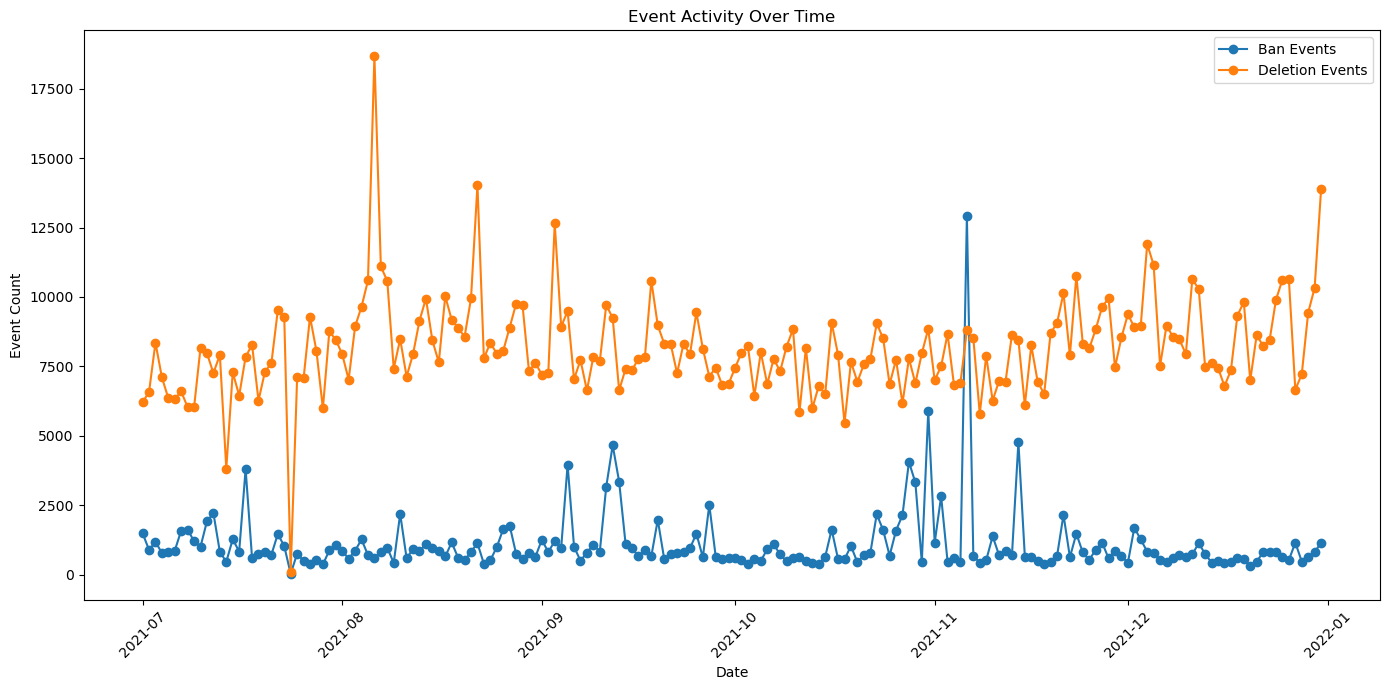

In [42]:
import matplotlib.pyplot as plt

# Convert to Pandas for plotting
daily_counts_pd = daily_counts.toPandas()

# Set the date as the index
daily_counts_pd.set_index('date', inplace=True)

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(daily_counts_pd.index, daily_counts_pd['ban_count'], label='Ban Events', marker='o', linestyle='-')
plt.plot(daily_counts_pd.index, daily_counts_pd['deletion_count'], label='Deletion Events', marker='o', linestyle='-')

plt.title('Event Activity Over Time')
plt.xlabel('Date')
plt.ylabel('Event Count')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Analysis of Ban and Deletion Events Over Time in VTuber Live Chat Streams
This portion analyzes the daily occurrence of two types of moderation events—ban and deletion events—in VTuber live chat streams over the period from mid-2021 to early 2022. By examining the trends and frequency of these events, we aim to uncover patterns in moderation behavior and understand the dynamics of viewer interaction and content management in virtual live-streaming environments. The following are the findings: 

1. Event Frequency and Trends: 
Deletion Events: Deletion events consistently outnumber ban events throughout the period. This indicates that message deletion is a more common moderation response than banning users, suggesting that moderators prioritize content control over restricting user access. This could reflect a moderation policy aimed at maintaining community standards while minimizing user exclusion.
Ban Events: Although less frequent, ban events show a steady occurrence, with some days experiencing noticeable spikes. This implies that while banning is used sparingly, there are specific instances where it becomes necessary, potentially due to severe violations of community guidelines.

2. Spikes in Moderation Activity: 
The analysis reveals significant peaks in both ban and deletion events during certain periods. For instance:
August 2021: A sharp increase in deletion events is observed. This spike could suggest a response to specific content issues or an increase in user engagement that required more active moderation.
November 2021: Another peak occurs, with both ban and deletion events reaching higher-than-average levels. This may correspond to external factors, such as policy updates, platform changes, or increased viewer activity, which might have led to more intensive moderation.

3. Moderation Consistency: 
Both types of events display a degree of regularity, with daily fluctuations but no long-term trend indicating a rise or fall in moderation levels. This consistency suggests an ongoing need for moderation, possibly driven by the high engagement typical of VTuber live streams and the diversity of viewer interactions.

4. Comparative Trends: 
The regular disparity between deletion and ban events highlights that message deletion is the preferred moderation method, with bans reserved for more severe cases. This could indicate a moderation approach that seeks to preserve viewer participation while ensuring community standards are upheld.

In [43]:
# Extracting hour from timestamp for filtered ban and deletion events
ban_hourly_counts = filtered_df_ban_events.withColumn("hour", F.hour("timestamp")) \
    .groupBy("hour").count().withColumnRenamed("count", "ban_count")

deletion_hourly_counts = filtered_df_deletion_events.withColumn("hour", F.hour("timestamp")) \
    .groupBy("hour").count().withColumnRenamed("count", "deletion_count")

# Joining all hourly counts into a single DataFrame
hourly_counts = ban_hourly_counts \
    .join(deletion_hourly_counts, "hour", "outer") \
    .fillna(0)  # Fill NaNs with 0 for missing counts

# Show the resulting hourly counts DataFrame
hourly_counts.show()

+----+---------+--------------+
|hour|ban_count|deletion_count|
+----+---------+--------------+
|   0|     3916|         25100|
|   1|     4691|         30205|
|   2|     4839|         30659|
|   3|     4623|         39145|
|   4|     6441|         40996|
|   5|     7813|         39803|
|   6|     5527|         40534|
|   7|     4997|         39218|
|   8|     6895|         43042|
|   9|     5855|         54540|
|  10|     5825|         74194|
|  11|    23702|        110112|
|  12|    27189|        156578|
|  13|    31853|        188811|
|  14|    18803|        177509|
|  15|     9587|        136199|
|  16|     5463|         87169|
|  17|     3620|         52776|
|  18|     2926|         33306|
|  19|     2110|         21395|
+----+---------+--------------+
only showing top 20 rows



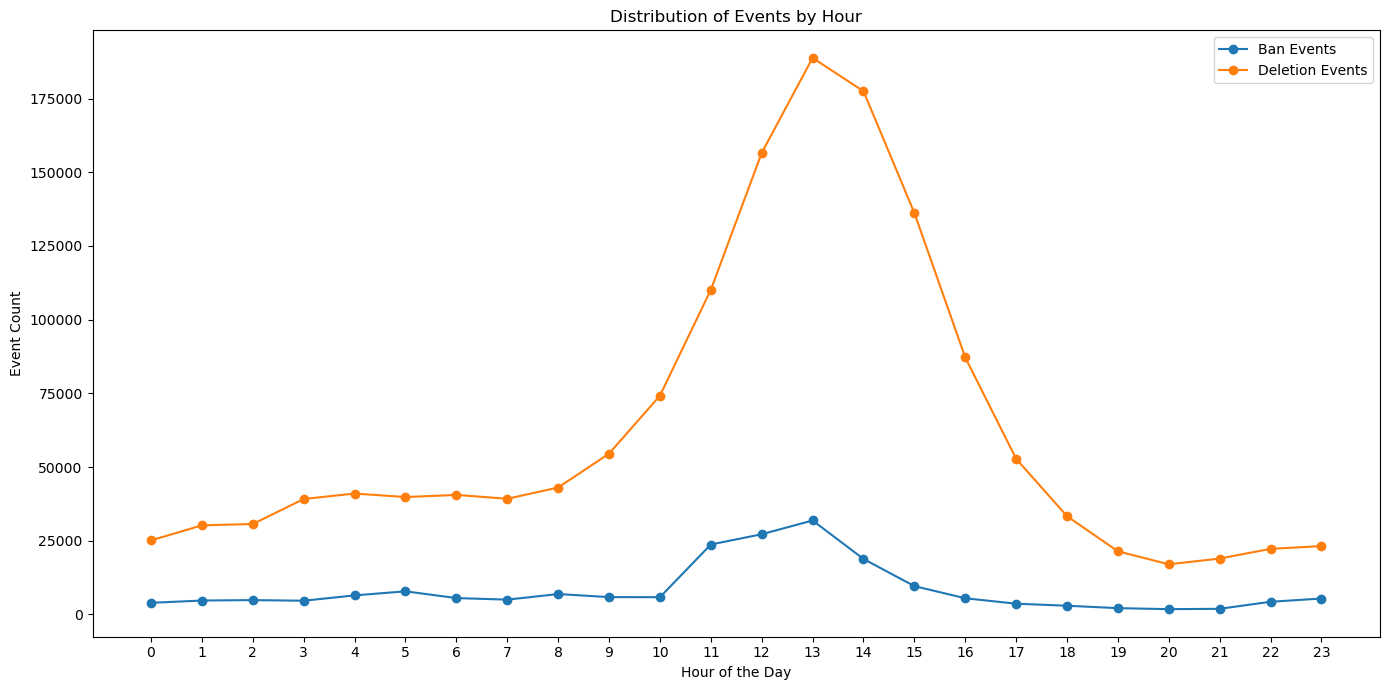

In [44]:
# Convert to Pandas for plotting
hourly_counts_pd = hourly_counts.toPandas()

# Set the hour as the index
hourly_counts_pd.set_index('hour', inplace=True)

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(hourly_counts_pd.index, hourly_counts_pd['ban_count'], label='Ban Events', marker='o', linestyle='-')
plt.plot(hourly_counts_pd.index, hourly_counts_pd['deletion_count'], label='Deletion Events', marker='o', linestyle='-')

plt.title('Distribution of Events by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Event Count')
plt.legend()
plt.xticks(range(24))  # Show hours from 0 to 23
plt.tight_layout()
plt.show()

## Analysis of Ban and Deletion Events by Hour in VTuber Live Chat Streams

This analysis examines the distribution of two types of moderation events—ban and deletion events—throughout the 24-hour day in VTuber live chat streams. By analyzing these events on an hourly basis, we aim to identify peak times for moderation activity, which could provide insights into viewer behavior patterns and moderation needs during live-streaming sessions. Shown are the findings: 

1. Hourly Distribution and Trends
Deletion Events: Deletion events show a distinct peak during the midday hours, with activity rapidly rising from around 10 AM, peaking at approximately noon to 1 PM, and then tapering off by the evening. This pattern suggests that the highest need for content moderation occurs in the early afternoon, possibly due to increased viewer activity during this time.
Ban Events: In contrast, ban events display a relatively consistent distribution throughout the day, with a slight increase observed around the same midday period as deletion events. However, the peak in ban events is significantly lower in magnitude compared to deletion events, indicating that banning is less frequently applied than message deletion.

2. Midday Peak in Moderation Activity
The most notable observation is the sharp spike in deletion events around noon. This may correspond to peak engagement times when the largest audience is actively participating in live chats, leading to a higher likelihood of message removal due to policy violations or inappropriate content.
The ban events also exhibit a minor increase during this period, suggesting that some cases escalate from content deletion to user restrictions. However, the relatively flat trend for ban events across other hours implies that banning users is reserved for specific instances rather than a routine action.

3. Comparative Trends
The significant disparity between deletion and ban events, particularly during peak hours, highlights a preference for content removal over user restriction. This approach may reflect moderation policies that aim to manage content while minimizing user exclusion.
The hourly analysis further reveals that, unlike deletion events, ban events do not exhibit substantial hourly variation, indicating that most bans may occur independently of specific times or spikes in viewer activity.

## Text Content Analysis (Chats and Superchats)

/tmp/ipykernel_26556/1949166439.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='isMember', y='count', data=membership_counts, palette='Set1')


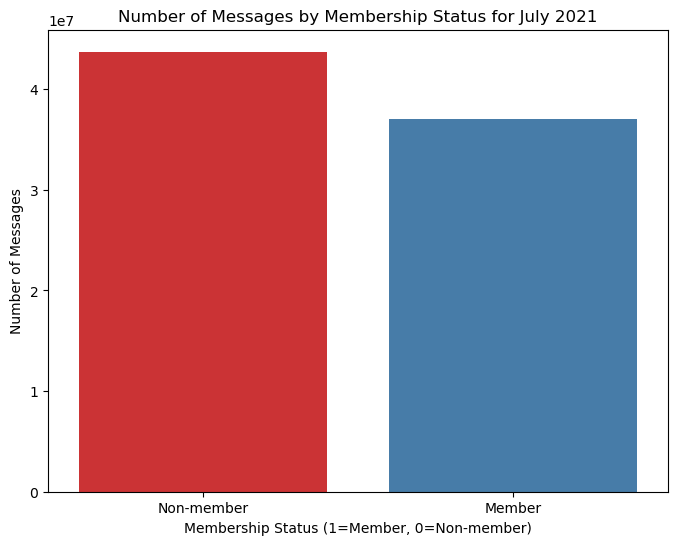

In [45]:
# Specify the file path for July 2021 chat data
file_path_july = "/mnt/data/public/vtuber/chats_2021-07.parquet"

# Read the chat data for July
df_july = spark.read.parquet(file_path_july)

# Step 1: Aggregate counts by membership status
membership_counts_spark = df_july.groupBy("isMember").agg(F.count('*').alias('count'))

# Step 2: Convert to Pandas DataFrame
membership_counts = membership_counts_spark.toPandas()

# Step 3: Set up the plot for July's data
plt.figure(figsize=(8, 6))
sns.barplot(x='isMember', y='count', data=membership_counts, palette='Set1')
plt.title('Number of Messages by Membership Status for July 2021')
plt.xlabel('Membership Status (1=Member, 0=Non-member)')
plt.ylabel('Number of Messages')
plt.xticks(ticks=[0, 1], labels=['Non-member', 'Member'], rotation=0)
plt.show()

/tmp/ipykernel_26556/4041200037.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='isMember', y='count', data=membership_counts, palette='Set1')


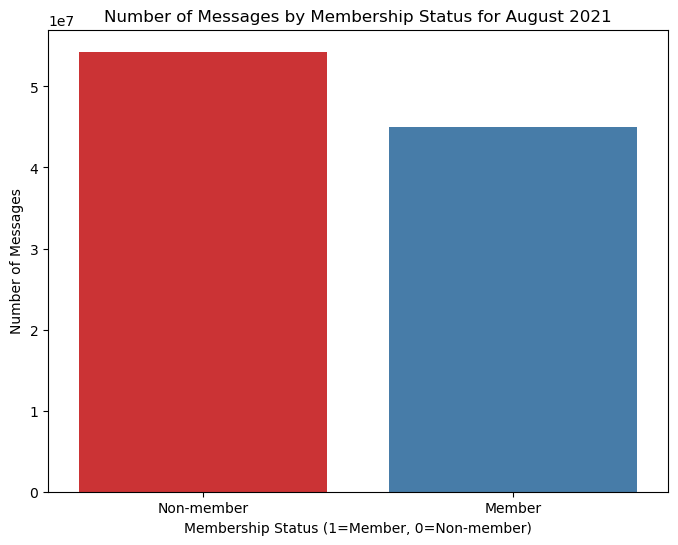

In [46]:
# Specify the file path for August 2021 chat data
file_path_august = "/mnt/data/public/vtuber/chats_2021-08.parquet"

# Read the chat data for August
df_august = spark.read.parquet(file_path_august)

# Step 1: Aggregate counts by membership status
membership_counts_spark = df_august.groupBy("isMember").agg(F.count('*').alias('count'))

# Step 2: Convert to Pandas DataFrame
membership_counts = membership_counts_spark.toPandas()

# Step 3: Set up the plot for August's data
plt.figure(figsize=(8, 6))
sns.barplot(x='isMember', y='count', data=membership_counts, palette='Set1')
plt.title('Number of Messages by Membership Status for August 2021')
plt.xlabel('Membership Status (1=Member, 0=Non-member)')
plt.ylabel('Number of Messages')
plt.xticks(ticks=[0, 1], labels=['Non-member', 'Member'], rotation=0)
plt.show()

/tmp/ipykernel_26556/827843011.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='isMember', y='count', data=membership_counts, palette='Set1')


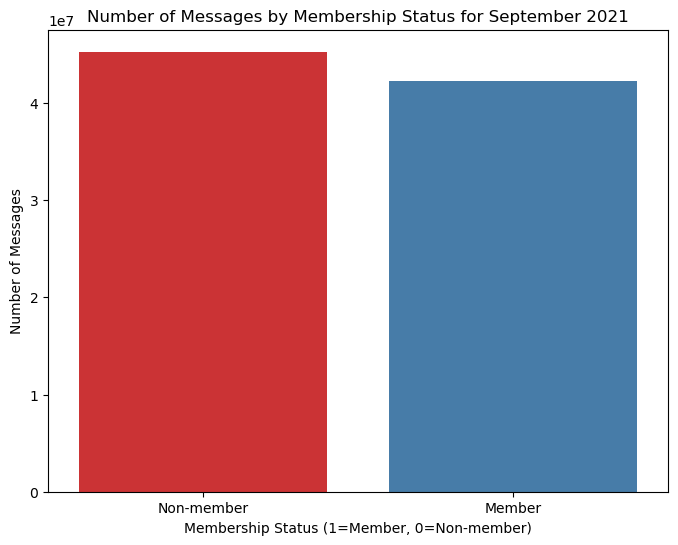

In [47]:
# Specify the file path for September 2021 chat data
file_path_september = "/mnt/data/public/vtuber/chats_2021-09.parquet"

# Read the chat data for September
df_september = spark.read.parquet(file_path_september)

# Step 1: Aggregate counts by membership status
membership_counts_spark = df_september.groupBy("isMember").agg(F.count('*').alias('count'))

# Step 2: Convert to Pandas DataFrame
membership_counts = membership_counts_spark.toPandas()

# Step 3: Set up the plot for September's data
plt.figure(figsize=(8, 6))
sns.barplot(x='isMember', y='count', data=membership_counts, palette='Set1')
plt.title('Number of Messages by Membership Status for September 2021')
plt.xlabel('Membership Status (1=Member, 0=Non-member)')
plt.ylabel('Number of Messages')
plt.xticks(ticks=[0, 1], labels=['Non-member', 'Member'], rotation=0)
plt.show()

/tmp/ipykernel_26556/2292352070.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='isMember', y='count', data=membership_counts, palette='Set1')


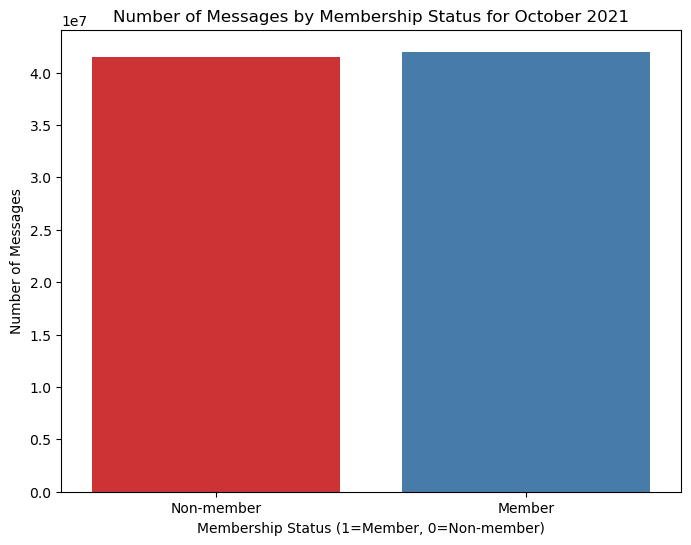

In [48]:
# Specify the file path for October 2021 chat data
file_path_october = "/mnt/data/public/vtuber/chats_2021-10.parquet"

# Read the chat data for October
df_october = spark.read.parquet(file_path_october)

# Step 1: Aggregate counts by membership status
membership_counts_spark = df_october.groupBy("isMember").agg(F.count('*').alias('count'))

# Step 2: Convert to Pandas DataFrame
membership_counts = membership_counts_spark.toPandas()

# Step 3: Set up the plot for October's data
plt.figure(figsize=(8, 6))
sns.barplot(x='isMember', y='count', data=membership_counts, palette='Set1')
plt.title('Number of Messages by Membership Status for October 2021')
plt.xlabel('Membership Status (1=Member, 0=Non-member)')
plt.ylabel('Number of Messages')
plt.xticks(ticks=[0, 1], labels=['Non-member', 'Member'], rotation=0)
plt.show()

/tmp/ipykernel_26556/3997295074.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='isMember', y='count', data=membership_counts, palette='Set1')


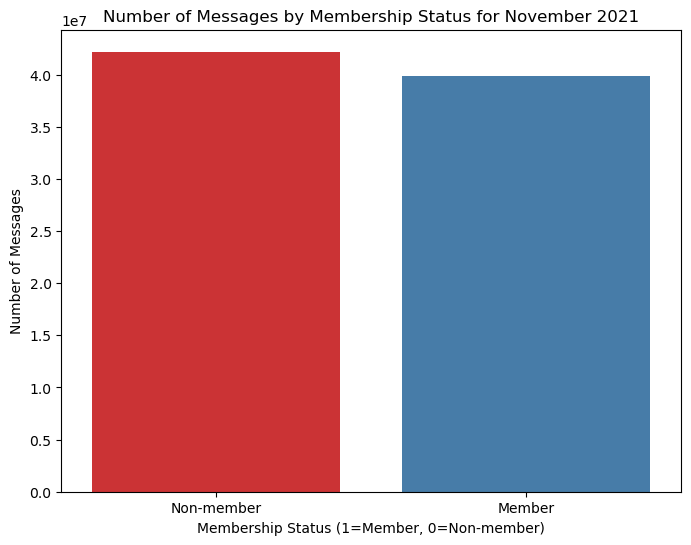

In [49]:
# Specify the file path for November 2021 chat data
file_path_november = "/mnt/data/public/vtuber/chats_2021-11.parquet"

# Read the chat data for November
df_november = spark.read.parquet(file_path_november)

# Step 1: Aggregate counts by membership status
membership_counts_spark = df_november.groupBy("isMember").agg(F.count('*').alias('count'))

# Step 2: Convert to Pandas DataFrame
membership_counts = membership_counts_spark.toPandas()

# Step 3: Set up the plot for November's data
plt.figure(figsize=(8, 6))
sns.barplot(x='isMember', y='count', data=membership_counts, palette='Set1')
plt.title('Number of Messages by Membership Status for November 2021')
plt.xlabel('Membership Status (1=Member, 0=Non-member)')
plt.ylabel('Number of Messages')
plt.xticks(ticks=[0, 1], labels=['Non-member', 'Member'], rotation=0)
plt.show()

This part examines the volume of messages sent by members and non-members in VTuber live chat streams for the month of July-November 2021. Using the isMember field, we distinguish between messages from members (paying supporters) and non-members (viewers without a paid membership). This breakdown provides insights into the engagement levels of different viewer segments.
Shown are the findings

1. Higher Engagement from Non-Members: The plot shows that non-members have a slightly higher message count compared to members. This indicates that the majority of chat activity is driven by non-members, which is common in public live streams where most viewers interact without subscribing to a paid membership.

2. Member Participation: Although members contribute fewer messages overall, the volume is still substantial. This suggests that members are actively engaged in the chat, likely taking advantage of their status to communicate with the VTuber or gain exclusive recognition. Member contributions represent a significant portion of the overall chat volume, highlighting the value they bring as part of the fanbase.

3. Implications for Engagement Strategy: 
Content for Non-Members: Given the high engagement from non-members, VTubers and content creators can focus on inclusive content that appeals to the broader audience while encouraging these viewers to consider membership.
Exclusive Engagement for Members: The substantial participation from members indicates that they are invested in the content. VTubers can enhance member benefits, such as exclusive chat interactions or special recognition, to further incentivize membership and retain this dedicated segment.


## Monetary Analysis

In [50]:
# Convert PySpark DataFrame to Pandas DataFrame
pandas_df_combined_superchats = df_combined_superchats.toPandas()

In [51]:
# Amount and Currency Analysis
currency_summary = pandas_df_combined_superchats.groupby('currency')['amount'].agg(['sum', 'mean', 'count']).reset_index()
currency_summary.columns = ['Currency', 'Total Amount', 'Average Amount', 'Count']
currency_summary = currency_summary.sort_values(by='Total Amount', ascending=False)

print("Currency Summary:")
currency_summary

Currency Summary:


,Currency,Total Amount,Average Amount,Count
27,JPY,1.934544e+09,1215.807276,1591160
29,KRW,3.620305e+08,12160.099993,29772
48,TWD,4.186760e+07,186.868056,224049
10,CLP,2.363030e+07,2863.585070,8252
11,COP,2.026196e+07,11120.721734,1822
37,PHP,5.117774e+06,193.987358,26382
43,RUB,3.789804e+06,254.502958,14891
39,PYG,3.435000e+06,20205.882353,170
20,HKD,3.203793e+06,66.386088,48260
49,USD,2.486775e+06,12.027292,206761


In [52]:
exchange_rates = {
    'AED': 0.27,      # United Arab Emirates Dirham
    'ARS': 0.0028,    # Argentine Peso
    'AUD': 0.64,      # Australian Dollar
    'BAM': 0.55,      # Bosnia-Herzegovina Convertible Mark
    'BGN': 0.55,      # Bulgarian Lev
    'BOB': 0.14,      # Bolivian Boliviano
    'BRL': 0.20,      # Brazilian Real
    'BYN': 0.39,      # Belarusian Ruble
    'CAD': 0.73,      # Canadian Dollar
    'CHF': 1.1,       # Swiss Franc
    'CLP': 0.0011,    # Chilean Peso
    'COP': 0.00025,   # Colombian Peso
    'CRC': 0.0019,    # Costa Rican Colón
    'CZK': 0.043,     # Czech Koruna
    'DKK': 0.14,      # Danish Krone
    'DOP': 0.017,     # Dominican Peso
    'EGP': 0.032,     # Egyptian Pound
    'EUR': 1.07,      # Euro
    'GBP': 1.23,      # British Pound
    'GTQ': 0.13,      # Guatemalan Quetzal
    'HKD': 0.13,      # Hong Kong Dollar
    'HNL': 0.041,     # Honduran Lempira
    'HRK': 0.14,      # Croatian Kuna
    'HUF': 0.0027,    # Hungarian Forint
    'ILS': 0.26,      # Israeli New Shekel
    'INR': 0.012,     # Indian Rupee
    'ISK': 0.0074,    # Icelandic Króna
    'JPY': 0.0067,    # Japanese Yen
    'KES': 0.0066,    # Kenyan Shilling
    'KRW': 0.00076,   # South Korean Won
    'MAD': 0.10,      # Moroccan Dirham
    'MXN': 0.056,     # Mexican Peso
    'MYR': 0.21,      # Malaysian Ringgit
    'NIO': 0.027,     # Nicaraguan Córdoba
    'NOK': 0.09,      # Norwegian Krone
    'NZD': 0.58,      # New Zealand Dollar
    'PEN': 0.27,      # Peruvian Sol
    'PHP': 0.018,     # Philippine Peso
    'PLN': 0.24,      # Polish Zloty
    'PYG': 0.00014,   # Paraguayan Guarani
    'QAR': 0.27,      # Qatari Riyal
    'RON': 0.21,      # Romanian Leu
    'RSD': 0.0091,    # Serbian Dinar
    'RUB': 0.011,     # Russian Ruble
    'SAR': 0.27,      # Saudi Riyal
    'SEK': 0.092,     # Swedish Krona
    'SGD': 0.73,      # Singapore Dollar
    'TRY': 0.036,     # Turkish Lira
    'TWD': 0.031,     # New Taiwan Dollar
    'USD': 1.0,       # United States Dollar
    'UYU': 0.025,     # Uruguayan Peso
    'ZAR': 0.052      # South African Rand
}

In [53]:
# Adding a USD conversion to the currency_summary DataFrame
currency_summary['Total Amount (USD)'] = currency_summary.apply(
    lambda row: row['Total Amount'] * exchange_rates.get(row['Currency'], 1), axis=1
)

# Sort by Total Amount (USD) for the top 5 currencies
top_5_currency_summary_usd = currency_summary.sort_values(by='Total Amount (USD)', ascending=False).head(5)

print("Top 5 Currency Summary (in USD):")
top_5_currency_summary_usd[['Currency', 'Total Amount (USD)', 'Average Amount', 'Count']]

Top 5 Currency Summary (in USD):


,Currency,Total Amount (USD),Average Amount,Count
27,JPY,1.296144e+07,1215.807276,1591160
49,USD,2.486775e+06,12.027292,206761
48,TWD,1.297896e+06,186.868056,224049
20,HKD,4.164930e+05,66.386088,48260
29,KRW,2.751432e+05,12160.099993,29772


/tmp/ipykernel_26556/305255897.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


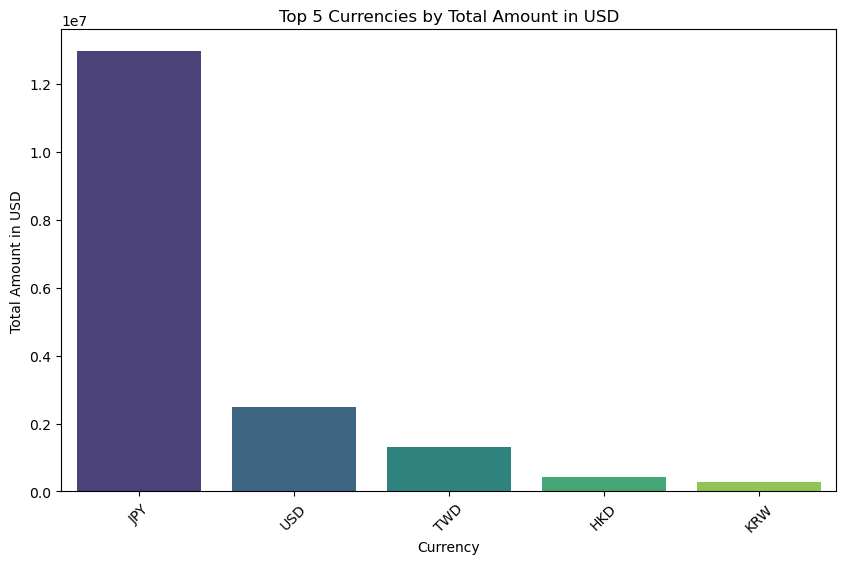

In [54]:
# Set up the top 5 currencies in USD for visualization
top_5_currency_summary_usd = currency_summary.sort_values(by='Total Amount (USD)', ascending=False).head(5)

# Plot settings
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_5_currency_summary_usd,
    x='Currency',
    y='Total Amount (USD)',
    palette='viridis'
)

# Add labels and title
plt.title('Top 5 Currencies by Total Amount in USD')
plt.xlabel('Currency')
plt.ylabel('Total Amount in USD')
plt.xticks(rotation=45)
plt.show()

### Currency Analysis Context

The currency analysis of the VTuber 1B dataset provides insights into the financial engagement patterns of VTuber audiences worldwide. This analysis focuses on three key areas: diverse audience reach, top currency contributions, and distinct engagement patterns across different currencies.

#### 1. Diverse Audience Reach
The VTuber 1B dataset showcases audience diversity through monetary contributions in various currencies, reflecting the international appeal of VTubers. Each currency indicates specific fan demographics, revealing:

- **High-frequency currencies** like JPY, USD, and TWD represent areas with substantial engagement, highlighting the consistent financial support from dedicated viewer bases.
- **Broad spectrum of currencies**: Contributions in HKD, KRW, PHP, and others demonstrate a wide fan engagement across different countries, emphasizing VTubers’ global reach.

This diversity signifies a unique digital culture that transcends borders, providing valuable insights for VTuber agencies and creators in strategizing content for their geographically diverse audiences.

#### 2. Top Currency Contributions (in USD)
By converting contributions to USD, we gain a standardized view of financial engagement. The top five currencies based on total contributions are:

- **JPY (Japanese Yen)**: The highest total, indicating strong financial backing from Japanese fans, known for their deep-rooted fan culture.
- **USD (United States Dollar)**: Significant contributions from a large, engaged English-speaking audience.
- **TWD (New Taiwan Dollar)**: Highlights a dedicated viewer base in Taiwan with substantial financial involvement.
- **HKD (Hong Kong Dollar)**: Reflects a strong, engaged fanbase in Hong Kong.
- **KRW (South Korean Won)**: Shows fewer but larger contributions, indicating a trend of substantial but less frequent transactions.

These findings reveal the scale and diversity of support within the VTuber community, allowing creators to better target their audience.

#### 3. Patterns of Engagement
Distinct patterns emerge in how fans from different regions use superchats, shedding light on cultural differences:

- **Japan (JPY)**: High volume of regular, smaller superchats indicates strong emotional connections.
- **South Korea (KRW)**: Larger but less frequent contributions suggest substantial single transactions tied to milestones.
- **United States (USD)**: Moderate average contributions with high frequency reflect a balanced support approach.
- **Taiwan (TWD) and Hong Kong (HKD)**: Similar to Japan, with steady contributions indicating consistent engagement.

These regional differences illustrate how cultural factors influence fan interactions with VTubers, enabling creators to tailor content and engagement strategies accordingly.

## Exploring Relationships

In [55]:
# Author Engagement Across Channels
author_channel_engagement = pandas_df_combined_superchats.groupby('authorChannelId')['channelId'].nunique().reset_index()
author_channel_engagement.columns = ['Author Channel ID', 'Distinct Channels']
avg_engagement = author_channel_engagement['Distinct Channels'].mean()

In [56]:
print(f"Average distinct channels engaged by authors: {avg_engagement}")

Average distinct channels engaged by authors: 2.0584771222167735


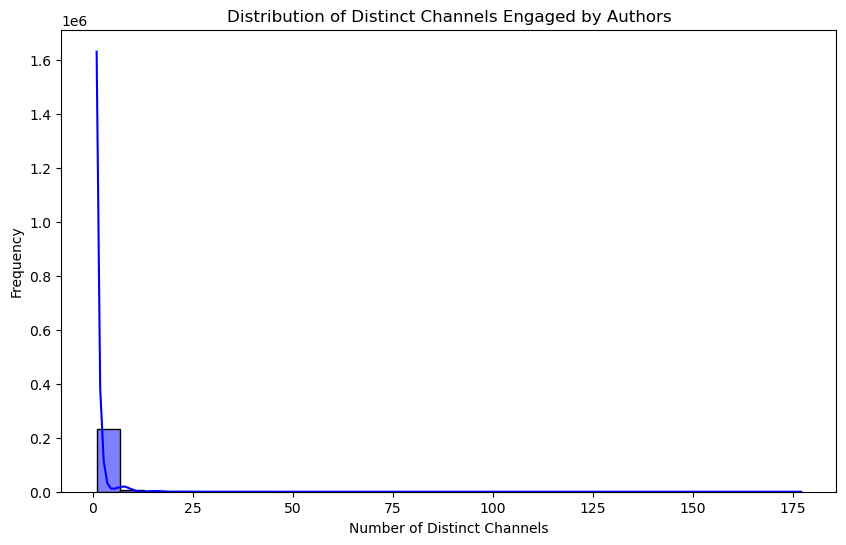

In [57]:
plt.figure(figsize=(10, 6))
sns.histplot(author_channel_engagement['Distinct Channels'], bins=30, kde=True, color='blue')
plt.title('Distribution of Distinct Channels Engaged by Authors')
plt.xlabel('Number of Distinct Channels')
plt.ylabel('Frequency')
plt.show()

In [58]:
# Channel Specific Patterns for bans and deletions
ban_channel_counts = filtered_df_ban_events.groupBy('channelId').count().orderBy('count', ascending=False)
deletion_channel_counts = filtered_df_deletion_events.groupBy('channelId').count().orderBy('count', ascending=False)

In [59]:
# Show the top channels with the most bans
print("Top Channels with Most Bans:")
ban_channel_counts.show(10)

# Show the top channels with the most deletions
print("Top Channels with Most Deletions:")
deletion_channel_counts.show(10)

Top Channels with Most Bans:
+--------------------+-----+
|           channelId|count|
+--------------------+-----+
|UCdn5BQ06XqgXoAxI...|24319|
|UC-hM6YJuNYVAmUWx...|10671|
|UCCzUftO8KOVkV4wQ...| 8448|
|UCajhBT4nMrg3DLS-...| 7373|
|UC6tSB9TnO0f01OBe...| 7141|
|UCJFZiqLMntJufDCH...| 7021|
|UCp-5t9SrOQwXMU7i...| 6508|
|UCvInZx9h3jC2JzsI...| 4986|
|UCZlDXzGoo7d44bwd...| 4909|
|UCyl1z3jo3XHR1riL...| 4558|
+--------------------+-----+
only showing top 10 rows

Top Channels with Most Deletions:
+--------------------+-----+
|           channelId|count|
+--------------------+-----+
|UCSFCh5NL4qXrAy9u...|32689|
|UC6wvdADTJ88OfIbJ...|29058|
|UC1DCedRgGHBdm81E...|27312|
|UCmZ1Rbthn-6Jm_qO...|22780|
|UC-6rZgmxZSIbq786...|21122|
|UCspv01oxUFf_MTSi...|20361|
|UCgmFrRcyH7d1zR9s...|19604|
|UCvzGlP9oQwU--Y0r...|18664|
|UC-hM6YJuNYVAmUWx...|17967|
|UC8oPnditPSp5lZu4...|16908|
+--------------------+-----+
only showing top 10 rows



### Top Channels with Most Bans and Deletions

**Top Channels with Most Bans:**

| Channel ID               | Bans  |
|--------------------------|-------|
| UCdn5BQ06XqgXoAxI...    | 24,319|
| UC-hM6YJuNYVAmUWx...    | 10,671|
| UCCzUftO8KOVkV4wQ...    | 8,448 |
| UCajhBT4nMrg3DLS-...    | 7,373 |
| UC6tSB9TnO0f01OBe...    | 7,141 |

**Top Channels with Most Deletions:**

| Channel ID               | Deletions |
|--------------------------|-----------|
| UCSFCh5NL4qXrAy9u...    | 32,689    |
| UC6wvdADTJ88OfIbJ...    | 29,058    |
| UC1DCedRgGHBdm81E...    | 27,312    |
| UCmZ1Rbthn-6Jm_qO...    | 22,780    |
| UC-6rZgmxZSIbq786...    | 21,122    |

**Insights:**

- The channel with the highest number of bans, **UCdn5BQ06XqgXoAxI...**, has 24,319 bans recorded, while the channel with the highest number of deletions, **UCSFCh5NL4qXrAy9u...**, has an even greater count of 32,689 deletions.
- Notably, **UC-hM6YJuNYVAmUWx...** appears in both lists, indicating that it has experienced significant moderation activity in the form of both bans and deletions.

The dataset is structured to facilitate frequency analysis, focusing on essential columns to optimize loading times in environments like Kaggle Kernels. The bans and deletions recorded correspond to the actions of marking chat items by author as deleted, highlighting the interaction dynamics within VTuber communities.

<a id='Problem'></a>
<h1 style="color:#ffffff; background-color:#FF0000; border: 1px solid #ffffff; padding: 10px 0;">V. Conclusion </h1>

The ban and deletion events across VTuber live chat streams, combined with the currency analysis and engagement patterns by membership status, provides a comprehensive view of the financial, moderation, and engagement dynamics within the VTuber community. Key findings highlight distinct patterns in moderation activities, audience engagement through superchats, cultural variations in financial contributions, and engagement differences between members and non-members.

Moderation analysis shows that deletion events occur significantly more frequently than ban events, especially around midday, aligning with peak viewer engagement times. This suggests a moderation strategy focused on content control, with deletion events used to manage chat content and ban events applied selectively. Additionally, certain channels exhibit notably high moderation activity. Channels with high volumes of bans and deletions may indicate either larger, more active communities or channels that experience frequent disruptive behavior requiring moderation.

The currency analysis contextualizes the VTuber community's financial engagement across different regions. With a broad spectrum of currencies, this dataset reflects the global reach of VTubers. High-frequency currencies, such as JPY, USD, and TWD, highlight significant engagement from Japan, the United States, and Taiwan, each showcasing distinct fan behavior. Japanese viewers, for instance, contribute with high volumes of small superchats, suggesting a strong, emotionally connected fanbase, whereas South Korean fans contribute larger, less frequent amounts, indicative of milestone-based support. Channels can leverage these insights to tailor content to the preferences of their geographically diverse audiences.

The analysis of message activity by membership status reveals that non-members generate a slightly higher message volume compared to members, suggesting that most chat activity is driven by general viewers rather than paying supporters. However, members contribute a substantial portion of messages, indicating active engagement and the potential value they add to the fanbase. This distinction between member and non-member participation provides valuable insights for VTuber channels in crafting engagement strategies.